In [2]:
# Importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import re
import sklearn
import scipy as sp
import plotly.graph_objects as go
from prophet import Prophet
from plotly.subplots import make_subplots
from sklearn import datasets, model_selection, metrics
from scipy.stats import ttest_ind, boxcox, pearsonr
from scipy import stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor


from prophet import Prophet

print("Libraries successfully imported!")


/Users/mustafaaldabbas/anaconda3/envs/myenv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Libraries successfully imported!


### Understanding the Data

* Invoice id: Unique identifier for each transaction
* Branch: Identifies the branch (A, B, C)
* City: Location of the branches
* Customer type: Member or Normal
* Gender: Gender of the customer
* Product line: Category of the product
* Unit price: Price per unit of the product
* Quantity: Number of units purchased
* Tax: 5% tax on the total price
* Total: Total price including tax
* Date: Date of purchase
* Time: Time of purchase
* Payment: Payment method used
* COGS: Cost of goods sold
* Gross margin percentage: Gross margin percentage
* Gross income: Gross income
* Rating: Customer rating

#### Loading and preparing the data


In [3]:
#import dataset
df = pd.read_csv("/Users/mustafaaldabbas/Documents/GitHub/Machine_learning_superstore/Dataset/Mustafa Datasets /df_cleaned.csv")
df.head()

,invoice_id,branch,city,customer_type,gender,product_line,unit_price,quantity,tax_5,total,date,time,payment,cogs,gross_margin_percentage,gross_income,rating
0,750-67-8428,A,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,2019-01-05,2024-08-06 13:08:00,Ewallet,522.83,4.761905,26.1415,9.1
1,226-31-3081,C,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,2019-03-08,2024-08-06 10:29:00,Cash,76.40,4.761905,3.8200,9.6
2,631-41-3108,A,Yangon,Normal,Male,Home and lifestyle,46.33,7,16.2155,340.5255,2019-03-03,2024-08-06 13:23:00,Credit card,324.31,4.761905,16.2155,7.4
3,123-19-1176,A,Yangon,Member,Male,Health and beauty,58.22,8,23.2880,489.0480,2019-01-27,2024-08-06 20:33:00,Ewallet,465.76,4.761905,23.2880,8.4
4,373-73-7910,A,Yangon,Normal,Male,Sports and travel,86.31,7,30.2085,634.3785,2019-02-08,2024-08-06 10:37:00,Ewallet,604.17,4.761905,30.2085,5.3


2. create new dataframe from specific columns

In [4]:
# Convert the date column to datetime format
df['date'] = pd.to_datetime(df['date'])

# Extract year, month, and day from the date column
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day

# Aggregate sales data by date
Total_Sales_by_date = df.groupby('date')['total'].sum().reset_index()

# Extract year, month, and day from the date column
Total_Sales_by_date['year'] = Total_Sales_by_date['date'].dt.year
Total_Sales_by_date['month'] = Total_Sales_by_date['date'].dt.month
Total_Sales_by_date['day'] = Total_Sales_by_date['date'].dt.day

# Display the first few rows of the aggregated sales data
Total_Sales_by_date.tail()

,date,total,year,month,day
84,2019-03-26,1962.5130,2019,3,26
85,2019-03-27,2902.8195,2019,3,27
86,2019-03-28,2229.4020,2019,3,28
87,2019-03-29,4023.2430,2019,3,29
88,2019-03-30,4487.0595,2019,3,30


In [5]:
# Aggregate additional columns by date and city separately
additional_columns = df.groupby(['date', 'branch'])
additional_columns

## Create new features 

In [6]:
# Create a new DataFrame with the specified columns
df1 = df[['date', 'unit_price', 'quantity', 'branch', 'rating', 'day', 'month', 'year', 'total']]
# Sort the DataFrame by date in ascending order
df1 = df1.sort_values(by='date')
df1

,date,unit_price,quantity,branch,rating,day,month,year,total
856,2019-01-01,21.12,8,B,6.3,1,1,2019,177.408
567,2019-01-01,65.74,9,A,7.7,1,1,2019,621.243
245,2019-01-01,47.59,8,A,5.7,1,1,2019,399.756
696,2019-01-01,27.04,4,A,6.9,1,1,2019,113.568
523,2019-01-01,62.87,2,C,5.0,1,1,2019,132.027
...,...,...,...,...,...,...,...,...,...
158,2019-03-30,97.22,9,B,6.0,30,3,2019,918.729
881,2019-03-30,10.18,8,C,9.5,30,3,2019,85.512
963,2019-03-30,96.82,3,C,6.7,30,3,2019,304.983
937,2019-03-30,89.48,5,A,7.4,30,3,2019,469.770


In [7]:
print(Total_Sales_by_date.columns)

Index(['date', 'total', 'year', 'month', 'day'], dtype='object')


### 3. EDA to see total sales over time in all branches A, B , C

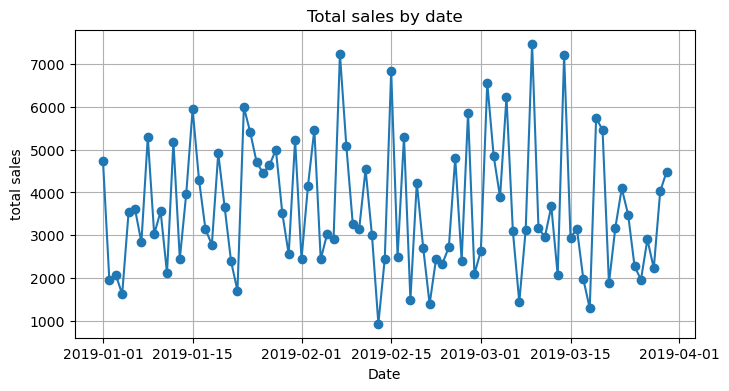

In [8]:
# Plot the total sales over time
plt.figure(figsize=(8, 4))
plt.plot(Total_Sales_by_date['date'], Total_Sales_by_date['total'], marker='o')
plt.title('Total sales by date')
plt.xlabel('Date')
plt.ylabel('total sales')
plt.grid(True)
plt.show()

### Next Steps in EDA
1- Seasonal Decomposition:
* Perform a seasonal decomposition to understand the trend, seasonality, and residual components.

2- Moving Average:
* Plot a moving average to smooth out short-term fluctuations and highlight longer-term trends.

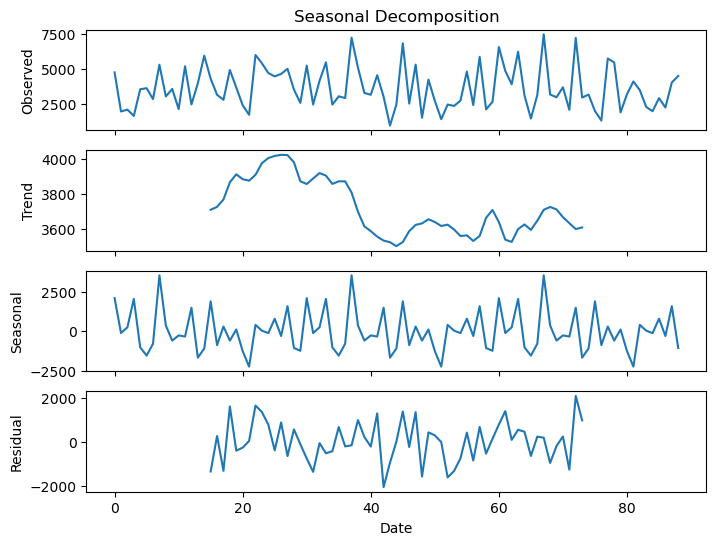

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform seasonal decomposition
decomposition = seasonal_decompose(Total_Sales_by_date['total'], model='additive', period=30)

# Plot the decomposition results
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(8, 6), sharex=True)

ax1.plot(decomposition.observed)
ax1.set_ylabel('Observed')
ax1.set_title('Seasonal Decomposition')

ax2.plot(decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(decomposition.resid)
ax4.set_ylabel('Residual')
ax4.set_xlabel('Date')

plt.show()

##### The seasonal decomposition plot shows the observed data, trend, seasonal component, and residuals. Here's a summary of the components:
- **Observed:** The original Gross income data.
- **Trend:** The overall direction of the data over time.
- **Seasonal:** Repeating patterns at a fixed period (monthly in this case).
- **Residual:** The remaining variations after removing the trend and seasonal components.

### 4. Feature engineering

1. Create Separate DataFrames for Each Branch:1. Create Separate DataFrames for Each Branch:

In [10]:
# Create separate DataFrames for each branch
branch_a_df = df1[df1['branch'] == 'A']
branch_b_df = df1[df1['branch'] == 'B']
branch_c_df = df1[df1['branch'] == 'C']


2. Aggregate Data for Each Branch:

In [11]:
# Function to aggregate data for a branch
def aggregate_branch_data(branch_df):
    return branch_df.groupby('date').agg({
        'unit_price': 'mean',
        'quantity': 'sum',
        'rating': 'mean',
        'day': 'first',
        'month': 'first',
        'year': 'first',
        'total': 'sum'
    }).reset_index()

# Aggregate for each branch
branch_a_agg = aggregate_branch_data(branch_a_df)
branch_b_agg = aggregate_branch_data(branch_b_df)
branch_c_agg = aggregate_branch_data(branch_c_df)

# Add branch identifier
branch_a_agg['branch'] = 'A'
branch_b_agg['branch'] = 'B'
branch_c_agg['branch'] = 'C'


3. Concatenate Aggregated DataFrames:

In [34]:
# Concatenate the DataFrames
combined_df = pd.concat([branch_a_agg, branch_b_agg, branch_c_agg], ignore_index=True)

# Convert the 'date' column to datetime format and sort
combined_df['date'] = pd.to_datetime(combined_df['date'])
combined_df = combined_df.sort_values(by='date').reset_index(drop=True)
combined_df.to_csv('combined_df.csv')


4. One-Hot Encoding of Categorical Variables:


In [13]:
# One-hot encode the 'branch' column
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(drop='first', sparse=False)
branch_encoded = encoder.fit_transform(combined_df[['branch']])

# Create a DataFrame with the one-hot encoded branch data
branch_encoded_df = pd.DataFrame(branch_encoded, columns=encoder.get_feature_names_out(['branch']))

# Concatenate the one-hot encoded columns to the original dataframe
combined_df_encoded = pd.concat([combined_df.drop(columns=['branch']), branch_encoded_df], axis=1)


5. Shift Lag and Rolling Lag Moving Average:

In [14]:
# Create lagged versions of 'quantity' and 'unit_price'
combined_df_encoded['quantity_lag1'] = combined_df_encoded['quantity'].shift(1)
combined_df_encoded['unit_price_lag1'] = combined_df_encoded['unit_price'].shift(1)

# Create rolling averages of 'quantity' and 'unit_price' with a window of 7
combined_df_encoded['quantity_roll7'] = combined_df_encoded['quantity'].rolling(window=7).mean()
combined_df_encoded['unit_price_roll7'] = combined_df_encoded['unit_price'].rolling(window=7).mean()


6. Transform 'Day' Column into Sine and Cosine Components:

In [15]:
# Transform 'day' column into sine and cosine components
combined_df_encoded['day_sin'] = np.sin(2 * np.pi * combined_df_encoded['day'] / 31)
combined_df_encoded['day_cos'] = np.cos(2 * np.pi * combined_df_encoded['day'] / 31)


7. Drop Rows with NaN Values and Calculate Rows Lost:

In [16]:
# Drop rows with NaN values resulting from the lag and rolling operations
combined_df_encoded_dropped = combined_df_encoded.dropna().reset_index(drop=True)

combined_df_encoded_dropped

,date,unit_price,quantity,rating,day,month,year,total,branch_B,branch_C,quantity_lag1,unit_price_lag1,quantity_roll7,unit_price_roll7,day_sin,day_cos
0,2019-01-03,53.376667,19,7.500000,3,1,2019,937.4085,0.0,0.0,10.0,65.745000,21.142857,51.745357,0.571268,0.820763
1,2019-01-03,48.500000,3,8.400000,3,1,2019,124.0260,0.0,1.0,19.0,53.376667,16.285714,50.468214,0.571268,0.820763
2,2019-01-03,72.843333,15,8.533333,3,1,2019,1016.6940,1.0,0.0,3.0,48.500000,15.000000,52.281071,0.571268,0.820763
3,2019-01-04,66.650000,9,9.700000,4,1,2019,629.8425,0.0,1.0,15.0,72.843333,13.428571,54.935000,0.724793,0.688967
4,2019-01-04,62.433333,8,4.866667,4,1,2019,510.5835,1.0,0.0,9.0,66.650000,13.571429,57.844762,0.724793,0.688967
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252,2019-03-29,55.590000,14,5.350000,29,3,2019,985.6980,0.0,1.0,13.0,71.900000,15.142857,57.539810,-0.394356,0.918958
253,2019-03-29,68.947500,27,7.700000,29,3,2019,2059.9320,1.0,0.0,14.0,55.590000,17.714286,53.129452,-0.394356,0.918958
254,2019-03-30,57.142500,23,7.775000,30,3,2019,1320.6165,0.0,0.0,27.0,68.947500,17.857143,53.919524,-0.201299,0.979530
255,2019-03-30,87.730000,19,5.366667,30,3,2019,1724.4570,1.0,0.0,23.0,57.142500,15.571429,59.575238,-0.201299,0.979530


### Model Development 
#### Train Test Split


In [17]:
# Prepare the data
from sklearn.model_selection import train_test_split

# Prepare the data
features = combined_df_encoded_dropped.drop(columns=['date','total'])
target = combined_df_encoded_dropped['total']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

#### Normalization

In [18]:
from sklearn.preprocessing import MinMaxScaler
normalizer = MinMaxScaler()

#Fit it to our training data
#Transforming our training and testing data
X_train_norm = normalizer.fit_transform(X_train)
X_test_norm = normalizer.transform(X_test)

X_train_norm = pd.DataFrame(X_train_norm, columns = X_train.columns)
X_test_norm = pd.DataFrame(X_test_norm, columns = X_test.columns)


#### Model 1: Linear Regression
- MSE (Mean Squared Error): Lower is better.
- RMSE (Root Mean Squared Error): Lower is better.
- MAE (Mean Absolute Error): Lower is better.
- R² Score: Higher is better.

In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

# Initialize the Linear Regressor
linear_model = LinearRegression()

# Train the Linear Regression model
linear_model.fit(X_train, y_train)

# Make predictions on the test set
linear_predictions = linear_model.predict(X_test)

# Calculate evaluation metrics
linear_mse = mean_squared_error(y_test, linear_predictions)
linear_rmse = np.sqrt(linear_mse)
linear_mae = mean_absolute_error(y_test, linear_predictions)
linear_r2 = r2_score(y_test, linear_predictions)

# Print the results
print('Mean Squared Error (MSE):', linear_mse)
print('Root Mean Squared Error (RMSE):', linear_rmse)
print('Mean Absolute Error (MAE):', linear_mae)
print('R2 Score:', linear_r2)


Mean Squared Error (MSE): 39061.377943373016
Root Mean Squared Error (RMSE): 197.63951513645497
Mean Absolute Error (MAE): 153.2399170238527
R2 Score: 0.9512265726254266


 #### Model 2:  Decision Tree Regressor

In [20]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

# Train the Decision Tree Regressor
dt_model = DecisionTreeRegressor(max_depth=10)
dt_model.fit(X_train, y_train)

# Make predictions
dt_predictions = dt_model.predict(X_test)

# Calculate evaluation metrics
dt_mae = mean_absolute_error(y_test, dt_predictions)
dt_mse = mean_squared_error(y_test, dt_predictions)
dt_rmse = np.sqrt(dt_mse)
dt_r2 = r2_score(y_test, dt_predictions)

# Print the results
print('Mean Absolute Error (MAE):', dt_mae)
print('Mean Squared Error (MSE):', dt_mse)
print('Root Mean Squared Error (RMSE):', dt_rmse)
print('R2 Score:', dt_r2)



Mean Absolute Error (MAE): 254.46012980769228
Mean Squared Error (MSE): 120298.574708131
Root Mean Squared Error (RMSE): 346.84084924952396
R2 Score: 0.8497909160988228


### Model 3: Random Forest Regressor

In [21]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

# Train the Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
rf_predictions = rf_model.predict(X_test)

# Calculate evaluation metrics
rf_mse = mean_squared_error(y_test, rf_predictions)
rf_rmse = np.sqrt(rf_mse)
rf_mae = mean_absolute_error(y_test, rf_predictions)
rf_r2 = r2_score(y_test, rf_predictions)

# Print the results
print('Mean Squared Error (MSE):', rf_mse)
print('Root Mean Squared Error (RMSE):', rf_rmse)
print('Mean Absolute Error (MAE):', rf_mae)
print('R2 Score:', rf_r2)


Mean Squared Error (MSE): 65424.31630110095
Root Mean Squared Error (RMSE): 255.78177476337314
Mean Absolute Error (MAE): 174.47372048076937
R2 Score: 0.9183088690760274


### Model 4: Ensemple Methods: Gradient Boosting Regressor

In [22]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

# Train the Gradient Boosting Regressor
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)

# Make predictions
gb_predictions = gb_model.predict(X_test)

# Calculate evaluation metrics
gb_mse = mean_squared_error(y_test, gb_predictions)
gb_rmse = np.sqrt(gb_mse)
gb_mae = mean_absolute_error(y_test, gb_predictions)
gb_r2 = r2_score(y_test, gb_predictions)

# Print the results
print('Mean Squared Error (MSE):', gb_mse)
print('Root Mean Squared Error (RMSE):', gb_rmse)
print('Mean Absolute Error (MAE):', gb_mae)
print('R2 Score:', gb_r2)


Mean Squared Error (MSE): 41098.46144208309
Root Mean Squared Error (RMSE): 202.7275547183537
Mean Absolute Error (MAE): 153.76479519296706
R2 Score: 0.948682997633671


### Model 5: K-Nearest Neighbors Regressor

In [23]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

# Train the K-Nearest Neighbors Regressor
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train, y_train)

# Make predictions
knn_predictions = knn_model.predict(X_test)

# Calculate evaluation metrics
knn_mse = mean_squared_error(y_test, knn_predictions)
knn_rmse = np.sqrt(knn_mse)
knn_mae = mean_absolute_error(y_test, knn_predictions)
knn_r2 = r2_score(y_test, knn_predictions)

# Print the results
print('Mean Squared Error (MSE):', knn_mse)
print('Root Mean Squared Error (RMSE):', knn_rmse)
print('Mean Absolute Error (MAE):', knn_mae)
print('R2 Score:', knn_r2)


Mean Squared Error (MSE): 133839.4184493369
Root Mean Squared Error (RMSE): 365.84070091959
Mean Absolute Error (MAE): 292.2414923076923
R2 Score: 0.8328833364491859


### Model 6: CatBoost

In [24]:
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

# Initialize CatBoostRegressor
model = CatBoostRegressor(iterations=1000, depth=3, learning_rate=0.1, loss_function='RMSE', verbose=False)

# Train the model
model.fit(X_train, y_train) 

# Make predictions
predictions = model.predict(X_test)

# Calculate evaluation metrics
catboost_mse = mean_squared_error(y_test, predictions)
catboost_rmse = np.sqrt(catboost_mse)
catboost_mae = mean_absolute_error(y_test, predictions)
catboost_r2 = r2_score(y_test, predictions)

# Print the results
print('Mean Squared Error (MSE):', catboost_mse)
print('Root Mean Squared Error (RMSE):', catboost_rmse)
print('Mean Absolute Error (MAE):', catboost_mae)
print('R2 Score:', catboost_r2)


Mean Squared Error (MSE): 40401.85365357367
Root Mean Squared Error (RMSE): 201.00212350513533
Mean Absolute Error (MAE): 147.3118596871508
R2 Score: 0.9495528069228028


### Model 7: Ensemple Methods: LightGBM

In [25]:
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

# Initialize the LightGBM Regressor
lgb_model = LGBMRegressor(n_estimators=100, learning_rate=0.1, num_leaves=31)

# Train the LightGBM Regressor
lgb_model.fit(X_train, y_train)

# Make predictions
lgb_predictions = lgb_model.predict(X_test)

# Calculate evaluation metrics
lgb_mse = mean_squared_error(y_test, lgb_predictions)
lgb_rmse = np.sqrt(lgb_mse)
lgb_mae = mean_absolute_error(y_test, lgb_predictions)
lgb_r2 = r2_score(y_test, lgb_predictions)

# Print the results
print('Mean Squared Error (MSE):', lgb_mse)
print('Root Mean Squared Error (RMSE):', lgb_rmse)
print('Mean Absolute Error (MAE):', lgb_mae)
print('R2 Score:', lgb_r2)


Mean Squared Error (MSE): 88375.97242985482
Root Mean Squared Error (RMSE): 297.28096546845177
Mean Absolute Error (MAE): 227.76988177373357
R2 Score: 0.8896506139846482


### Model 9: Ensemple Methods:XGBoost

In [26]:
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Initialize the XGBoost Regressor
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)

# Train the XGBoost Regressor
xgb_model.fit(X_train, y_train)

# Make predictions
xgb_predictions = xgb_model.predict(X_test)

# Calculate evaluation metrics
xgb_mse = mean_squared_error(y_test, xgb_predictions)
xgb_rmse = np.sqrt(xgb_mse)
xgb_mae = mean_absolute_error(y_test, xgb_predictions)
xgb_r2 = r2_score(y_test, xgb_predictions)

# Print the results
print('Mean Squared Error (MSE):', xgb_mse)
print('Root Mean Squared Error (RMSE):', xgb_rmse)
print('Mean Absolute Error (MAE):', xgb_mae)
print('R2 Score:', xgb_r2)



Mean Squared Error (MSE): 52940.51571520263
Root Mean Squared Error (RMSE): 230.08806078369784
Mean Absolute Error (MAE): 178.60804929997371
R2 Score: 0.9338965870033789


### Model 10:ARIMA  (AutoRegressive Integrated Moving Average)

In [27]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

# Train ARIMA model
arima_model = ARIMA(y_train, order=(5, 1, 0))
arima_model_fit = arima_model.fit()

# Make predictions
arima_forecast = arima_model_fit.forecast(steps=len(y_test))
arima_predictions = arima_forecast.values

# Calculate evaluation metrics
arima_mse = mean_squared_error(y_test, arima_predictions)
arima_rmse = np.sqrt(arima_mse)
arima_mae = mean_absolute_error(y_test, arima_predictions)
arima_r2 = r2_score(y_test, arima_predictions)

# Print the results
print('Mean Squared Error (MSE):', arima_mse)
print('Root Mean Squared Error (RMSE):', arima_rmse)
print('Mean Absolute Error (MAE):', arima_mae)
print('R2 Score:', arima_r2)


Mean Squared Error (MSE): 832087.0435052434
Root Mean Squared Error (RMSE): 912.1880527091129
Mean Absolute Error (MAE): 749.2954283643796
R2 Score: -0.03897351098469559


/Users/mustafaaldabbas/anaconda3/envs/myenv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/mustafaaldabbas/anaconda3/envs/myenv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/mustafaaldabbas/anaconda3/envs/myenv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/mustafaaldabbas/anaconda3/envs/myenv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/mustafaaldabbas/anaconda3

### All results

In [35]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Initialize dictionary
results = {
    'Model': [],
    'RMSE': [],
    'MSE': [],
    'MAE': [],
    'R2 Score': []
}

# Add results for Linear Regression
results['Model'].append('Linear Regression')
results['RMSE'].append(linear_rmse)
results['MSE'].append(linear_mse)
results['MAE'].append(linear_mae)
results['R2 Score'].append(linear_r2)

# Add results for Decision Tree
results['Model'].append('Decision Tree')
results['RMSE'].append(dt_rmse)
results['MSE'].append(dt_mse)
results['MAE'].append(dt_mae)
results['R2 Score'].append(dt_r2)

# Add results for Random Forest
results['Model'].append('Random Forest')
results['RMSE'].append(rf_rmse)
results['MSE'].append(rf_mse)
results['MAE'].append(rf_mae)
results['R2 Score'].append(rf_r2)

# Add results for Gradient Boosting
results['Model'].append('Gradient Boosting')
results['RMSE'].append(gb_rmse)
results['MSE'].append(gb_mse)
results['MAE'].append(gb_mae)
results['R2 Score'].append(gb_r2)

# Add results for K-Nearest Neighbors
results['Model'].append('K-Nearest Neighbors')
results['RMSE'].append(knn_rmse)
results['MSE'].append(knn_mse)
results['MAE'].append(knn_mae)
results['R2 Score'].append(knn_r2)

# Add results for CatBoost
results['Model'].append('CatBoost')
results['RMSE'].append(catboost_rmse)
results['MSE'].append(catboost_mse)
results['MAE'].append(catboost_mae)
results['R2 Score'].append(catboost_r2)

# Add results for LightGBM
results['Model'].append('LightGBM')
results['RMSE'].append(lgb_rmse)
results['MSE'].append(lgb_mse)
results['MAE'].append(lgb_mae)
results['R2 Score'].append(lgb_r2)


# Add results for XGBoost
results['Model'].append('XGBoost')
results['RMSE'].append(xgb_rmse)
results['MSE'].append(xgb_mse)
results['MAE'].append(xgb_mae)
results['R2 Score'].append(xgb_r2)

# Add results for ARIMA
results['Model'].append('ARIMA')
results['RMSE'].append(arima_rmse)
results['MSE'].append(arima_mse)
results['MAE'].append(arima_mae)
results['R2 Score'].append(arima_r2)

# Convert dictionary to DataFrame
results_df = pd.DataFrame(results)

# Display the results
results_df.to_csv('results_of_models.csv')


In [29]:
# Sort by RMSE to find the best model
sorted_by_rmse = results_df.sort_values(by='RMSE')
print("Models sorted by RMSE:")
print(sorted_by_rmse)

# Sort by R² Score to find the best model
sorted_by_r2 = results_df.sort_values(by='R2 Score', ascending=False)
print("Models sorted by R² Score:")
print(sorted_by_r2)

Models sorted by RMSE:
                 Model        RMSE            MSE         MAE  R2 Score
0    Linear Regression  197.639515   39061.377943  153.239917  0.951227
5             CatBoost  201.002124   40401.853654  147.311860  0.949553
3    Gradient Boosting  202.727555   41098.461442  153.764795  0.948683
7              XGBoost  230.088061   52940.515715  178.608049  0.933897
2        Random Forest  255.781775   65424.316301  174.473720  0.918309
6             LightGBM  297.280965   88375.972430  227.769882  0.889651
1        Decision Tree  346.840849  120298.574708  254.460130  0.849791
4  K-Nearest Neighbors  365.840701  133839.418449  292.241492  0.832883
8                ARIMA  912.188053  832087.043505  749.295428 -0.038974
Models sorted by R² Score:
                 Model        RMSE            MSE         MAE  R2 Score
0    Linear Regression  197.639515   39061.377943  153.239917  0.951227
5             CatBoost  201.002124   40401.853654  147.311860  0.949553
3    Gradient 

#### Models sorted by RMSE:

    - Linear Regression: RMSE = 9.411405, R² Score = 0.951227
    - Gradient Boosting: RMSE = 9.503874, R² Score = 0.950263
    - CatBoost: RMSE = 9.571530, R² Score = 0.949553

####  Models sorted by R² Score:

    - Linear Regression: R² Score = 0.951227, RMSE = 9.411405
    - Gradient Boosting: R² Score = 0.950263, RMSE = 9.503874
    - CatBoost: R² Score = 0.949553, RMSE = 9.571530

####  Conclusion:
Linear Regression is the best model as it has the lowest RMSE (9.411405) and the highest R² Score (0.951227) among all models evaluated.

### Linear Regression Hyperparameter Tuning with Ridge Regression


In [30]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import numpy as np

# Define the parameter grid for Ridge Regression
param_grid = {
    'alpha': [0.1, 1, 10, 100]  # Regularization strength
}

# Initialize Ridge Regression model
ridge_model = Ridge()

# Set up Grid Search
grid_search = GridSearchCV(ridge_model, param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit Grid Search
grid_search.fit(X_train, y_train)

# Best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Make predictions with the best model
ridge_predictions = best_model.predict(X_test)

# Calculate evaluation metrics
ridge_mse = mean_squared_error(y_test, ridge_predictions)
ridge_rmse = np.sqrt(ridge_mse)
ridge_mae = mean_absolute_error(y_test, ridge_predictions)
ridge_r2 = r2_score(y_test, ridge_predictions)

# Print results
print('Best Ridge Parameters:', best_params)
print('Ridge Mean Squared Error (MSE):', ridge_mse)
print('Ridge Root Mean Squared Error (RMSE):', ridge_rmse)
print('Ridge Mean Absolute Error (MAE):', ridge_mae)
print('Ridge R^2 Score:', ridge_r2)

Best Ridge Parameters: {'alpha': 100}
Ridge Mean Squared Error (MSE): 39199.268034053144
Ridge Root Mean Squared Error (RMSE): 197.98805023044483
Ridge Mean Absolute Error (MAE): 152.11490481512686
Ridge R^2 Score: 0.9510543981482946


In [31]:
# previous results before Hyperparameter Tuning with Ridge Regression
print('Mean Squared Error (MSE):', linear_mse)
print('Root Mean Squared Error (RMSE):', linear_rmse)
print('Mean Absolute Error (MAE):', linear_mae)
print('R2 Score:', linear_r2)

Mean Squared Error (MSE): 39061.377943373016
Root Mean Squared Error (RMSE): 197.63951513645497
Mean Absolute Error (MAE): 153.2399170238527
R2 Score: 0.9512265726254266


### Forecast using the Linear Regression Model


In [41]:
from datetime import datetime, timedelta
import numpy as np
import pandas as pd

# Assuming combined_df_encoded is already loaded

# List of features used in training (excluding 'total')
features = ['unit_price', 'quantity', 'rating', 'day', 'month', 'year',
            'branch_B', 'branch_C', 'quantity_lag1', 'unit_price_lag1',
            'quantity_roll7', 'unit_price_roll7', 'day_sin', 'day_cos']

# Verify the features in the combined_df_encoded
print("Features in the training data:", features)

# Generate future dates
last_date = combined_df_encoded['date'].max()
future_dates = [last_date + timedelta(days=i) for i in range(1, 8)]  # Predict for 7 days

# Create a DataFrame for the next 7 days
future_df = pd.DataFrame({'date': future_dates})

# Convert 'date' to datetime format if it's not already
future_df['date'] = pd.to_datetime(future_df['date'])

# Extract day, month, year, day_sin, and day_cos from the future dates
future_df['day'] = future_df['date'].dt.day
future_df['month'] = future_df['date'].dt.month
future_df['year'] = future_df['date'].dt.year
future_df['day_sin'] = np.sin(2 * np.pi * future_df['day'] / 30)
future_df['day_cos'] = np.cos(2 * np.pi * future_df['day'] / 30)

# Use the mean of the existing data for other features (unit_price, quantity, rating, branch_B, branch_C)
mean_values = combined_df_encoded[features].mean()

# Populate future_df with mean values where applicable
for feature in features:
    if feature not in future_df.columns:
        future_df[feature] = mean_values[feature]

# For lag and rolling features, use the last available values from combined_df_encoded
future_df['quantity_lag1'] = combined_df_encoded['quantity'].iloc[-1]
future_df['unit_price_lag1'] = combined_df_encoded['unit_price'].iloc[-1]
future_df['quantity_roll7'] = combined_df_encoded['quantity'].rolling(window=7).mean().iloc[-1]
future_df['unit_price_roll7'] = combined_df_encoded['unit_price'].rolling(window=7).mean().iloc[-1]

# Ensure that all columns have the same data types as in the training data
for feature in features:
    future_df[feature] = future_df[feature].astype(combined_df_encoded[feature].dtype)

# Ensure the order of columns matches the training set, excluding 'date'
future_df_ordered = future_df[features]

# Verify the order of features and the number of features
print("Features in the ordered future data:", future_df_ordered.columns)
print("Number of features in the ordered future data:", future_df_ordered.shape[1])
print("Number of features expected by the model:", best_model.n_features_in_)

# Check if best_model is defined and trained
try:
    best_model
except NameError:
    print("The model 'best_model' is not defined. Please ensure it is trained and available in the environment.")
    raise

# Use the trained Ridge Regression model to make predictions for the next 7 days
try:
    future_predictions = best_model.predict(future_df_ordered)
except Exception as e:
    print("Error during prediction:", e)
    raise

# Add 'date' column back to future_df for displaying predictions
future_df['date'] = future_dates

# Add predictions back to the DataFrame
future_df['total_predictions'] = future_predictions

# Display the predictions
future_df


Features in the training data: ['unit_price', 'quantity', 'rating', 'day', 'month', 'year', 'branch_B', 'branch_C', 'quantity_lag1', 'unit_price_lag1', 'quantity_roll7', 'unit_price_roll7', 'day_sin', 'day_cos']
Features in the ordered future data: Index(['unit_price', 'quantity', 'rating', 'day', 'month', 'year', 'branch_B',
       'branch_C', 'quantity_lag1', 'unit_price_lag1', 'quantity_roll7',
       'unit_price_roll7', 'day_sin', 'day_cos'],
      dtype='object')
Number of features in the ordered future data: 14
Number of features expected by the model: 14


,date,day,month,year,day_sin,day_cos,unit_price,quantity,rating,branch_B,branch_C,quantity_lag1,unit_price_lag1,quantity_roll7,unit_price_roll7,total_predictions
0,2019-03-31,31,3,2019,0.207912,0.978148,55.724261,20,6.938356,0.326996,0.334601,25.0,62.4325,18.714286,64.155595,1138.918529
1,2019-04-01,1,4,2019,0.207912,0.978148,55.724261,20,6.938356,0.326996,0.334601,25.0,62.4325,18.714286,64.155595,1133.271504
2,2019-04-02,2,4,2019,0.406737,0.913545,55.724261,20,6.938356,0.326996,0.334601,25.0,62.4325,18.714286,64.155595,1135.471973
3,2019-04-03,3,4,2019,0.587785,0.809017,55.724261,20,6.938356,0.326996,0.334601,25.0,62.4325,18.714286,64.155595,1138.084182
4,2019-04-04,4,4,2019,0.743145,0.669131,55.724261,20,6.938356,0.326996,0.334601,25.0,62.4325,18.714286,64.155595,1140.992514
5,2019-04-05,5,4,2019,0.866025,0.500000,55.724261,20,6.938356,0.326996,0.334601,25.0,62.4325,18.714286,64.155595,1144.068409
6,2019-04-06,6,4,2019,0.951057,0.309017,55.724261,20,6.938356,0.326996,0.334601,25.0,62.4325,18.714286,64.155595,1147.175983


### **Combine Historical and Future data and Visualize them** 

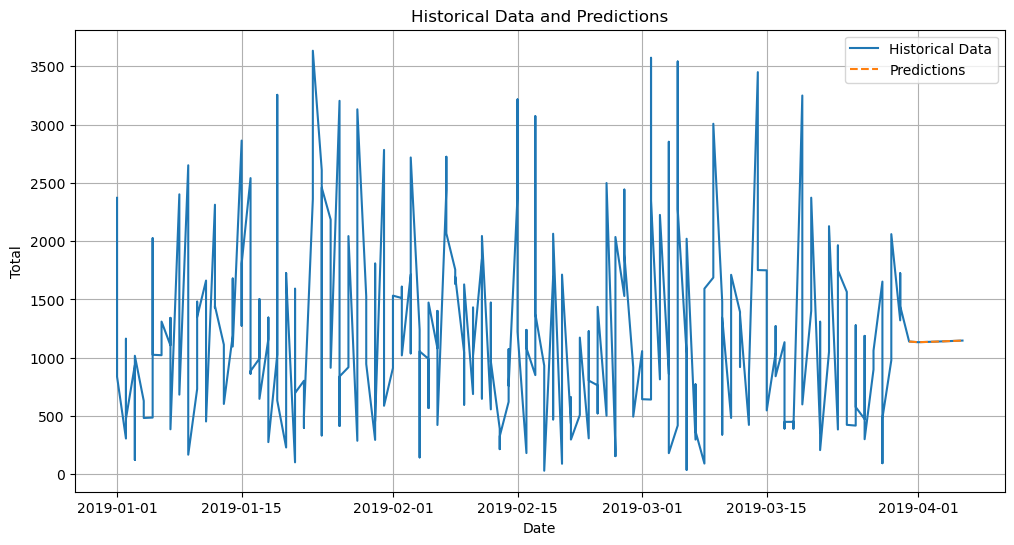

In [33]:
import matplotlib.pyplot as plt

# Combine historical data and future predictions
combined_df_encoded['date'] = pd.to_datetime(combined_df_encoded['date'])
predictions_df = future_df[['date', 'total_predictions']].rename(columns={'total_predictions': 'total'})
combined_data = pd.concat([combined_df_encoded[['date', 'total']], predictions_df], ignore_index=True)

# Plot the combined data
plt.figure(figsize=(12, 6))
plt.plot(combined_data['date'], combined_data['total'], label='Historical Data')
plt.plot(predictions_df['date'], predictions_df['total'], label='Predictions', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Total')
plt.title('Historical Data and Predictions')
plt.legend()
plt.grid(True)
plt.show()
